In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import pkg_resources


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

In [8]:
#Needs to be installed on Colab as well
!python -m spacy download en_core_web_lg -q

nlp = spacy.load('en_core_web_lg')

# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

2022-12-03 15:35:21.485387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-12-03 15:35:21.485436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 15:35:25.460593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-12-03 15:35:25.460627: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 15:35:25.464550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-BDR6HDN0
2022-12-03 15:35:25.464650: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-BDR6HDN0


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


True

In [3]:
#Gotta love the functions

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

#Knowledge Context Graph Functions

def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.7, val_split=0.10, test_split=0.20):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

In [4]:
# Entity Extraction Functions
# More useful info found here:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

In [5]:
#Visualization Utility Functions

def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [6]:
# Let's read in the dataset
v_df = pd.read_excel(r'youtube_links_with_metadatav3.xlsx')

v_df.head()

,Column1,link,title,author,publish_date,Subscribers,views,length_seconds,transcript
0,0,https://youtu.be/0JE-VbmzQzo,How to Change a Car Battery | DIY Car Repairs ...,The Home Depot,2020-07-08,507000,443403,140,"[, Music ], knowing how to change a car batter..."
1,1,https://youtu.be/OQGLZxPcd-o,How to change Car battery SAFELY - Which wire ...,Frakking Creations,2020-01-23,11400,273462,382,If your car has a battery that needs replacing...
2,2,https://youtu.be/79aMfc-SxzE,How To Replace Your Car Battery,Family Handyman,2020-11-20,127000,3803,105,"Hi, i'm joe with family handyman. You need to ..."
3,3,https://youtu.be/auhfI1zWBco,How To: Install a Battery in Your Vehicle,O'Reilly Auto Parts,2018-01-29,128000,856797,172,"[ Mechnical SFX ], Hey everybody, John here wi..."
4,4,https://youtu.be/gohJtZq54rU,How to change a car battery | carsales,carsales.com.au,2017-02-22,48100,21750,122,So your car has been getting harder and harder...


In [9]:
# From our experience, let's jettison the nonstandard characters right away
v_df['transcript'] = v_df['transcript'].apply(lambda x: ''.join([i if 32 < ord(i) < 126 else " " for i in x]))

# And let's tokenize the sentences
v_df['raw_sentences'] = v_df.transcript.apply(get_sentences)
v_df.head(3).T

,0,1,2
Column1,0,1,2
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery
author,The Home Depot,Frakking Creations,Family Handyman
publish_date,2020-07-08,2020-01-23,2020-11-20
Subscribers,507000,11400,127000
views,443403,273462,3803
length_seconds,140,382,105
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ..."
raw_sentences,"[[, Music ], knowing how to change a car batte...",[If your car has a battery that needs replacin...,"[Hi, i'm joe with family handyman., You need t..."


In [191]:
#Let's get granular! Tokenize words engage. Plus, let's define some stopwords.

default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({'', ''})
v_df['lemmas'] = v_df.transcript.apply(lambda x: get_lemmas(x, default_stopwords))
v_df.lemmas.head()

0    [music, know, change, car, battery, save, expe...
1    [car, battery, need, replace, want, want, sure...
2    [hi, joe, family, handyman, need, replace, car...
3    [mechnical, sfx, hey, everybody, john, oreilly...
4    [car, hard, hard, start, morning, come, comple...
Name: lemmas, dtype: object

In [192]:
# Lemmatized words... assemble!

v_df['lemmas_joined'] = v_df.lemmas.apply(lambda x: ' '.join(x))
v_df.head(3).T

,0,1,2
Column1,0,1,2
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery
author,The Home Depot,Frakking Creations,Family Handyman
publish_date,2020-07-08,2020-01-23,2020-11-20
Subscribers,507000,11400,127000
views,443403,273462,3803
length_seconds,140,382,105
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ..."
raw_sentences,"[[, Music ], knowing how to change a car batte...",[If your car has a battery that needs replacin...,"[Hi, i'm joe with family handyman., You need t..."


In [193]:
#Vocabulary data wrangling

vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(v_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=v_df.author)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

# Research opportunity: ignore terms that aren't within these frequencies... change the frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=4, max_df=.8)
transformed_documents = vectorizer.fit_transform(v_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=v_df.author)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 1755
Curated Vocabulary size: 444


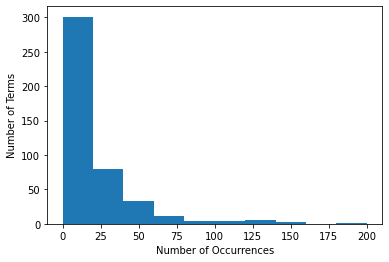

In [194]:
#Let's take a look at this in bar graph form

plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [195]:
# Re-tokenize words, recreate joined documents
v_df['lemmas'] = v_df.transcript.apply(lambda x: get_lemmas(x, words_to_remove))
v_df['lemmas_joined'] = v_df.lemmas.apply(lambda x: ' '.join(x))

# And get the lemmatized and filtered sentences
v_df['sentences_lemmatized']=\
v_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

v_df.head().T

,0,1,2,3,4
Column1,0,1,2,3,4
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE,https://youtu.be/auhfI1zWBco,https://youtu.be/gohJtZq54rU
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery,How To: Install a Battery in Your Vehicle,How to change a car battery | carsales
author,The Home Depot,Frakking Creations,Family Handyman,O'Reilly Auto Parts,carsales.com.au
publish_date,2020-07-08,2020-01-23,2020-11-20,2018-01-29,2017-02-22
Subscribers,507000,11400,127000,128000,48100
views,443403,273462,3803,856797,21750
length_seconds,140,382,105,172,122
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ...","[ Mechnical SFX ], Hey everybody, John here wi...",So your car has been getting harder and harder...
raw_sentences,"[[, Music ], knowing how to change a car batte...",[If your car has a battery that needs replacin...,"[Hi, i'm joe with family handyman., You need t...","[[ Mechnical SFX ], Hey everybody, John here w...",[So your car has been getting harder and harde...


In [196]:
#Lines of code to look at both raw sentences and lemmatized sentences.

#corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
corpus_text_sentences = [y for x in v_df.sentences_lemmatized for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'plus sign red plastic cover wear glove use wrench loosen nut black cable set aside away loosen nut end cable ahead clamp bracket secure set aside ready carefully tray use wire brush tray connector'

In [197]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]
entity_pairs

100%|██████████| 2168/2168 [00:13<00:00, 158.94it/s]


[['know change', 'trip repair shop'],
 ['', ''],
 ['', ''],
 ['engine', 'fully  start'],
 ['', 'black cover cable'],
 ['red plastic cover', 'carefully brush tray connector'],
 ['new  tray', 'new  spray'],
 ['post', 'secure cable cable'],
 ['close  hood', 'little test connection automotive'],
 ['replace', 'safely owner manual'],
 ['', 'trunk hood'],
 ['', 'vehicle memory saver'],
 ['lose', 'old security code power'],
 ['', 'memory'],
 ['trip youtube channel', 'subscribe channel check'],
 ['', ''],
 ['', ''],
 ['important safety prevent', ''],
 ['', ''],
 ['', ''],
 ['ground', 'directly body metal component'],
 ['', ''],
 ['big  spark', 'lead fire'],
 ['short metal cause circuit', 'directly metal cause spark'],
 ['', 'short circuit check manual'],
 ['typically millimeter socket', 'correct  cable'],
 ['body', 'short  circuit'],
 ['', ''],
 ['cable way', 'way touch step bracket'],
 ['', 'sure drop engine'],
 ['', ''],
 ['', 'new  step'],
 ['', ''],
 ['proper lift use core', 'clean cover tr

In [198]:
#Creates the dataframe for the source, target, and edge properties of the knowledge graph

relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [199]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

kg_df.tail(6).T

,2131,2134,2135,2155,2156,2158
source,cranking amp,i,sure loose,forward sit bracket,sit,tighten
target,far crank amp,thing,nice thing,place,little hold bracket place,sure way
edge,want big,pull,wait sure,come like,hold,check


In [200]:
len(corpus_text_sentences)

2168

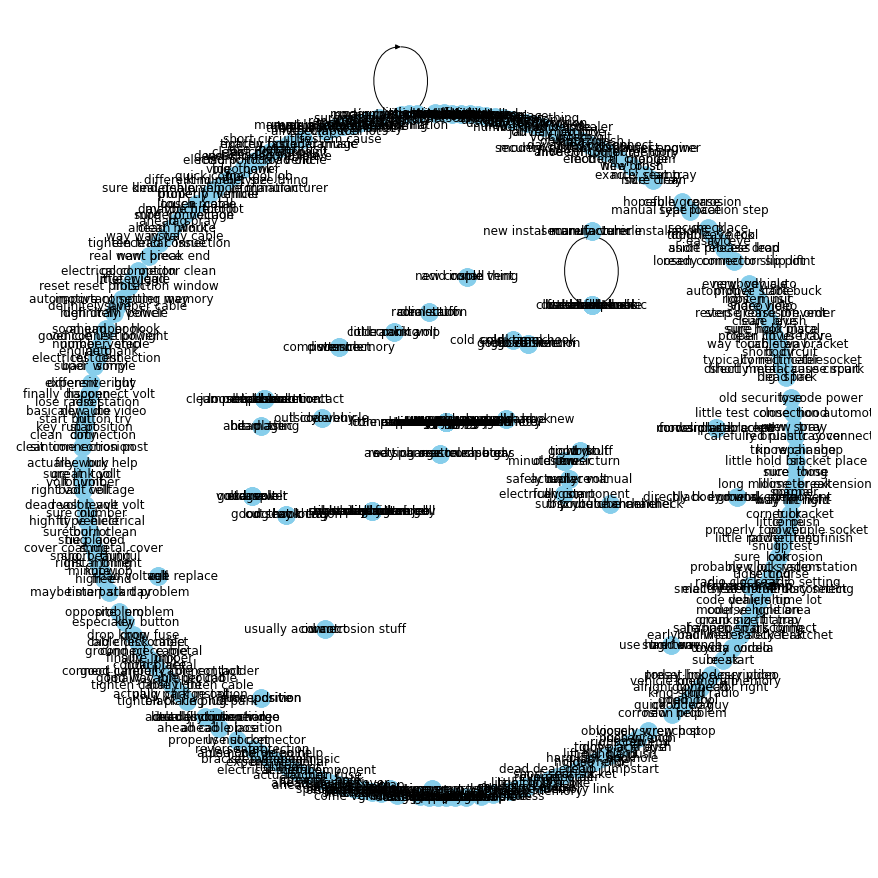

In [201]:
# Let's visualize ourselves a fancy knowledge graph

plot_graph(kg_df, use_circular=False)

In [202]:
#Let's take a look at the top sources and targets for the lemmatized sentences

get_top_sources_and_targets(kg_df, 25)

[('i', 15),
 ('thing', 14),
 ('guy', 8),
 ('reinstall', 7),
 ('cable', 6),
 ('use', 6),
 ('vehicle', 4),
 ('people', 4),
 ('new', 4),
 ('post', 3),
 ('place', 3),
 ('reason', 3),
 ('disconnect', 3),
 ('old', 3),
 ('step', 3),
 ('gas', 3),
 ('hook', 3),
 ('clamp', 3),
 ('case', 3),
 ('pop', 3),
 ('fastener music', 3),
 ('particular  model', 3),
 ('engine', 2),
 ('replace', 2),
 ('ground', 2)]

In [203]:
#Can't forget about the edges

get_top_edges(kg_df, 25)

[('want', 22),
 ('let', 16),
 ('start', 12),
 ('replace', 10),
 ('tighten', 9),
 ('lose', 8),
 ('connect', 6),
 ('try', 6),
 ('come', 6),
 ('use', 6),
 ('install new', 5),
 ('pull', 5),
 ('tell', 5),
 ('prevent', 4),
 ('remember', 4),
 ('watch', 4),
 ('happen', 4),
 ('know', 4),
 ('hold', 4),
 ('want sure', 4),
 ('install', 3),
 ('ve', 3),
 ('think', 3),
 ('save', 2),
 ('allow', 2)]

Text(1, 500, 'y = -91748.19 + 2.38x')

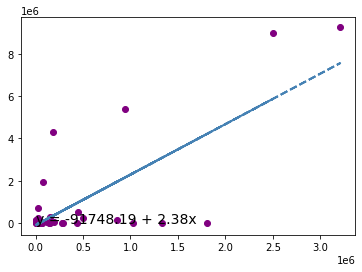

In [204]:
#sns.scatterplot(data = v_df, x = "views", y = "Subscribers")


#define data
x = v_df['views']
y = v_df['Subscribers']
#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
plt.scatter(x, y, color='purple')

#add line of best fit to plot
plt.plot(x, a*x+b, color='steelblue', linestyle='--', linewidth=2)

#add fitted regression equation to plot
plt.text(1, 500, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

In [10]:
v_df['Reach'] = v_df['views']/v_df['Subscribers']
v_df.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Column1,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE,https://youtu.be/auhfI1zWBco,https://youtu.be/gohJtZq54rU,https://youtu.be/JHo9RG0FXwQ,https://youtu.be/EWuz7GpeYqQ,https://youtu.be/N4uJIbPb8yU,https://youtu.be/lqd-A6bteqw,https://youtu.be/XN4GSRObmBA,...,https://youtu.be/uHieGuMrR60,https://youtu.be/UVaBPeaY0YE,https://youtu.be/ybXVBffMBLk,https://youtu.be/t-FFo6nEvw0,https://youtu.be/K-_kT8LTtDg,https://youtu.be/9HREVVZAqNI,https://youtu.be/KR5P2OGFj0Y,https://youtu.be/1QS0i3AwtfY,https://youtu.be/SBKaSQMxdt8,https://youtu.be/kq3ntBJLka0
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery,How To: Install a Battery in Your Vehicle,How to change a car battery | carsales,How to Replace a Car Battery Like a Pro,How to change a car battery,How to Replace a Car Battery | Mitre 10 Easy A...,How to Change Your Car Battery,How to Replace a Car Battery (the Right Way),...,1998-2008 Toyota Corolla Battery remove and in...,Cooley On Cars: How to change your car battery,Memory Keep Alive During Battery Replacement 101,DIY How to Replace Car Battery- Acura TSX/ CU2...,How to Replace a Car Battery (2009-2016 Toyota...,How to change your car battery without losing ...,Toyota Corolla (1995 - 2019) - New Battery Ins...,How to Change a Car Battery - Kia Sorento,"How To Change A Car Battery, Peugeot 107, Toyo...",How to Replace Car Battery Dodge Durango
author,The Home Depot,Frakking Creations,Family Handyman,O'Reilly Auto Parts,carsales.com.au,Interstate Batteries,Repco,Mitre 10 New Zealand,AutoZone,Scotty Kilmer,...,NutzAboutBolts,CNET Cars,The Snap-On Tool Review,Blu-TSX,Backyard Chevy,Charles Sparkes,The Battery Shop,Pink Caddy Garage,aaanton11,The Auto Teacher
publish_date,2020-07-08,2020-01-23,2020-11-20,2018-01-29,2017-02-22,2021-08-19,2018-05-18,2018-07-05,2022-02-08,2018-02-02,...,2014-08-14 00:00:00,2016-05-25 00:00:00,2017-10-09 00:00:00,2014-01-25 00:00:00,2019-09-25 00:00:00,2011-12-10 00:00:00,2021-03-31 00:00:00,2020-10-08 00:00:00,2020-04-10 00:00:00,2020-10-10 00:00:00
Subscribers,507000,11400,127000,128000,48100,5810,2490,251000,148000,5390000,...,71600,278000,44500,10200,43900,1660,17500,2560,34800,2690
views,443403,273462,3803,856797,21750,59350,30752,495589,3609,938046,...,117918,151420,146980,66468,58046,1028158,25441,25066,22607,63804
length_seconds,140,382,105,172,122,224,263,281,282,197,...,142,212,459,274,333,630,273,392,603,447
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ...","[ Mechnical SFX ], Hey everybody, John here wi...",So your car has been getting harder and harder...,"[, Music ], Hey there If you're watching this ...",This car is taking an unusual amount of time t...,"If your car's cranking, slowly or not at all, ...","You sound good mike, and i call you mike techn...","Rev up your engines today, I'm going to show y...",...,"Okay, right now we're going to remove our batt...",You know the sound your battery's dead and the...,"Yeah, what's up guys Joel back with you for an...",How'S it going guys today it is about 19 degre...,Hello in today's video we'll be replacing the ...,"Today, i'm going to show you how to change a c...","[, Music, ] hi, i'm katie, welcome to the batt...",Welcome to pink caddy garage today we're going...,"1:07, exactly the same mr. toyota, a guy mall,...",Today we have a 2015 dodge durango limited wit...
raw_sentences,"[[, Music ], knowing how to change a car batte...",[If your car has a battery that needs replacin...,"[Hi, i'm joe with family handyman., You need t...","[[ Mechnical SFX ], Hey everybody, John here w...",[So your car has been getting harder and harde...,"[[, Music ], Hey there If you're watching this...",[This car is t

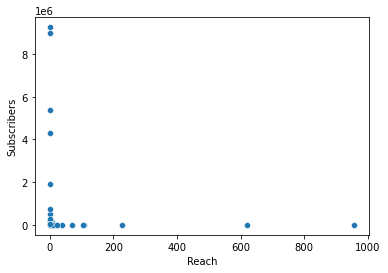

In [206]:
test = sns.scatterplot(data = v_df, x = "Reach", y = "Subscribers" )


#find line of best fit
#a, b = np.polyfit(v_df["Reach"], v_df["views"], 1)

#add line of best fit to plot
#plt.plot(v_df["Reach"], a*v_df["Reach"]+b)

In [11]:
v_df['Rating'] = pd.qcut(v_df['Reach'], q=4)


v_df['Rating'] = v_df['Rating'].astype("category")
v_df['Rating'] = v_df['Rating'].cat.codes
#v_df['Genre of Movie code'].tail().T

v_df['key'] = v_df['link'].str.split('be/').str[-1]
v_df.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Column1,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE,https://youtu.be/auhfI1zWBco,https://youtu.be/gohJtZq54rU,https://youtu.be/JHo9RG0FXwQ,https://youtu.be/EWuz7GpeYqQ,https://youtu.be/N4uJIbPb8yU,https://youtu.be/lqd-A6bteqw,https://youtu.be/XN4GSRObmBA,...,https://youtu.be/uHieGuMrR60,https://youtu.be/UVaBPeaY0YE,https://youtu.be/ybXVBffMBLk,https://youtu.be/t-FFo6nEvw0,https://youtu.be/K-_kT8LTtDg,https://youtu.be/9HREVVZAqNI,https://youtu.be/KR5P2OGFj0Y,https://youtu.be/1QS0i3AwtfY,https://youtu.be/SBKaSQMxdt8,https://youtu.be/kq3ntBJLka0
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery,How To: Install a Battery in Your Vehicle,How to change a car battery | carsales,How to Replace a Car Battery Like a Pro,How to change a car battery,How to Replace a Car Battery | Mitre 10 Easy A...,How to Change Your Car Battery,How to Replace a Car Battery (the Right Way),...,1998-2008 Toyota Corolla Battery remove and in...,Cooley On Cars: How to change your car battery,Memory Keep Alive During Battery Replacement 101,DIY How to Replace Car Battery- Acura TSX/ CU2...,How to Replace a Car Battery (2009-2016 Toyota...,How to change your car battery without losing ...,Toyota Corolla (1995 - 2019) - New Battery Ins...,How to Change a Car Battery - Kia Sorento,"How To Change A Car Battery, Peugeot 107, Toyo...",How to Replace Car Battery Dodge Durango
author,The Home Depot,Frakking Creations,Family Handyman,O'Reilly Auto Parts,carsales.com.au,Interstate Batteries,Repco,Mitre 10 New Zealand,AutoZone,Scotty Kilmer,...,NutzAboutBolts,CNET Cars,The Snap-On Tool Review,Blu-TSX,Backyard Chevy,Charles Sparkes,The Battery Shop,Pink Caddy Garage,aaanton11,The Auto Teacher
publish_date,2020-07-08,2020-01-23,2020-11-20,2018-01-29,2017-02-22,2021-08-19,2018-05-18,2018-07-05,2022-02-08,2018-02-02,...,2014-08-14 00:00:00,2016-05-25 00:00:00,2017-10-09 00:00:00,2014-01-25 00:00:00,2019-09-25 00:00:00,2011-12-10 00:00:00,2021-03-31 00:00:00,2020-10-08 00:00:00,2020-04-10 00:00:00,2020-10-10 00:00:00
Subscribers,507000,11400,127000,128000,48100,5810,2490,251000,148000,5390000,...,71600,278000,44500,10200,43900,1660,17500,2560,34800,2690
views,443403,273462,3803,856797,21750,59350,30752,495589,3609,938046,...,117918,151420,146980,66468,58046,1028158,25441,25066,22607,63804
length_seconds,140,382,105,172,122,224,263,281,282,197,...,142,212,459,274,333,630,273,392,603,447
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ...","[ Mechnical SFX ], Hey everybody, John here wi...",So your car has been getting harder and harder...,"[, Music ], Hey there If you're watching this ...",This car is taking an unusual amount of time t...,"If your car's cranking, slowly or not at all, ...","You sound good mike, and i call you mike techn...","Rev up your engines today, I'm going to show y...",...,"Okay, right now we're going to remove our batt...",You know the sound your battery's dead and the...,"Yeah, what's up guys Joel back with you for an...",How'S it going guys today it is about 19 degre...,Hello in today's video we'll be replacing the ...,"Today, i'm going to show you how to change a c...","[, Music, ] hi, i'm katie, welcome to the batt...",Welcome to pink caddy garage today we're going...,"1:07, exactly the same mr. toyota, a guy mall,...",Today we have a 2015 dodge durango limited wit...
raw_sentences,"[[, Music ], knowing how to change a car batte...",[If your car has a battery that needs replacin...,"[Hi, i'm joe with family handyman., You need t...","[[ Mechnical SFX ], Hey everybody, John here w...",[So your car has been getting harder and harde...,"[[, Music ], Hey there If you're watching this...",[This car is t

In [208]:
v_df.dtypes

Column1                   int64
link                     object
title                    object
author                   object
publish_date             object
Subscribers               int64
views                     int64
length_seconds            int64
transcript               object
raw_sentences            object
lemmas                   object
lemmas_joined            object
sentences_lemmatized     object
Reach                   float64
Rating                     int8
key                      object
dtype: object

In [209]:
v_df['Rating'].value_counts()

1    10
3    10
0    10
2    10
Name: Rating, dtype: int64

In [27]:
# Whoa, that's kinda messy... Maybe this will make sense when we develop the RNN model

datafull=v_df.copy() 
datafull.reset_index(drop=True, inplace=True)

#Let's do a little data preprocessing.

datafull['transcript'] = datafull['transcript'].apply(lambda x: clean_doc(x))

freshdf = datafull[['transcript','Rating']].copy()

freshdf['Rating'] = freshdf['Rating'].astype("category")
freshdf['Rating'] = freshdf['Rating'].cat.codes
freshdf['transcript'].tail()

35    Today , 'm going show change car battery witho...
36    [ , Music , ] hi , 'm katie , welcome battery ...
37    Welcome pink caddy garage today 're going quic...
38    1:07 , exactly mr. toyota , guy mall , c1 . Wh...
39    Today 2015 dodge durango limited 3.6 uh . The ...
Name: transcript, dtype: object

In [18]:
features, targets = freshdf['transcript'], freshdf['Rating']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=.2
                                                                              ,random_state=22
                                                                              ,shuffle = True
                                                                              ,stratify=targets)

In [29]:
# Let's create the training and testing datasets

trainds, valds, testds = get_dataset_partitions_pd(freshdf[['transcript','Rating']])
trainds.shape, valds.shape, testds.shape

((32, 2), (4, 2), (4, 2))

In [30]:
#And convert from dataframe to Tensorflow dataset

# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['transcript'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Rating'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['transcript'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Rating'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['transcript'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Rating'].values, tf.int64),
)

#Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

# Create Data Pipelines (Batching, Shuffling, and Optimizing)

batch_size = 1 #Research change parameter from 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


freshdf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  40 non-null     object
 1   Rating      40 non-null     int8  
dtypes: int8(1), object(1)
memory usage: 488.0+ bytes


In [155]:
# For more information: tf.keras.layers.TextVectorization
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

VOCAB_SIZE= 500 # Research experiment to see if adjusting vocab size can improve the model
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

vocab = np.array(encoder.get_vocabulary())
len(vocab)

500

In [135]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'battery', 's', 'car', 're', 'nt', 'terminal', 'i',
       'go', 'one', 'get', 'going', 'so', 'want', 'positive', 'make',
       'sure', 'negative', 'right'], dtype='<U13')

In [156]:
# Building the RNN sequential model

num_classes=4 # We have 4 ratings
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48,  return_sequences=True, dropout=0.0))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48,dropout=0.0))
   ,tf.keras.layers.Dense(32, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [157]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, None, 32)          16000     
                                                                 
 bidirectional_22 (Bidirecti  (None, None, 96)         31104     
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 96)               55680     
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 32)                3104      
                                                     

In [159]:
# Compiling the model

model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(train_ds
         ,steps_per_epoch=int(32/batch_size)           
         ,epochs=50
         ,validation_data=val_ds
         ,validation_steps=int(4/batch_size)
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/50
32/32 [==============================] - 66s 1s/step - loss: 1.3950 - accuracy: 0.1562 - val_loss: 1.3899 - val_accuracy: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 39s 1s/step - loss: 1.3850 - accuracy: 0.2188 - val_loss: 1.3846 - val_accuracy: 0.2500
Epoch 3/50
32/32 [==============================] - 40s 1s/step - loss: 1.3565 - accuracy: 0.4062 - val_loss: 1.3348 - val_accuracy: 0.0000e+00
Epoch 4/50
 5/32 [===>..........................] - ETA: 17s - loss: 1.1276 - accuracy: 0.8000

In [ ]:
# So, uh, how'd we do?

test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

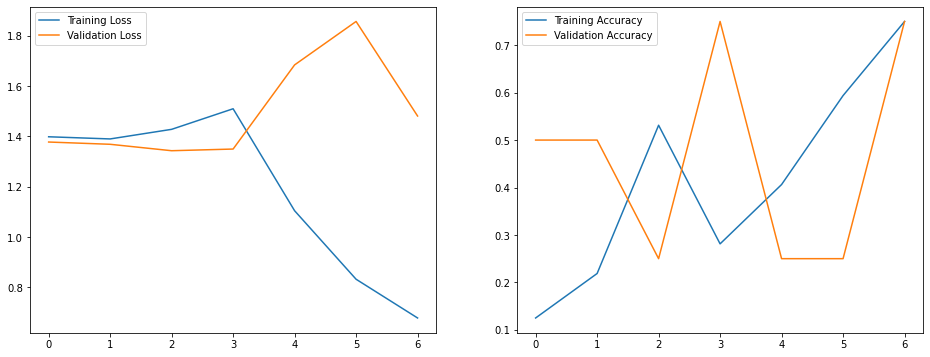

In [143]:
# Let's plot it

losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

4/4 [==============================] - 0s 75ms/step


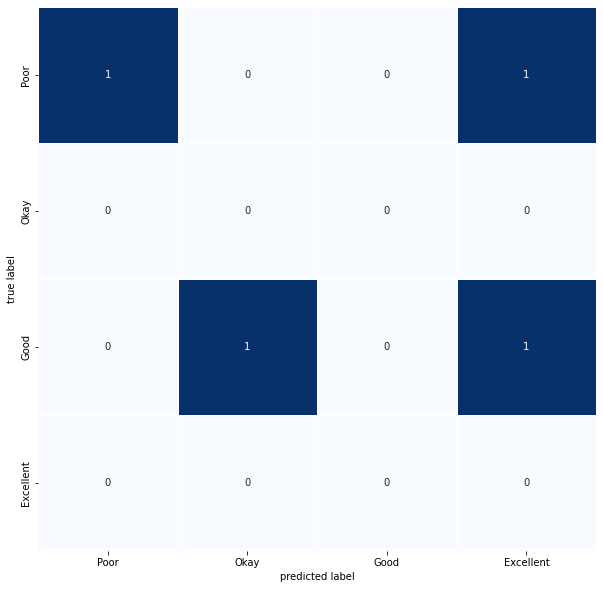

In [147]:
# And now for the confusion matrix

preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

CLASSES_LIST = ['Poor','Okay','Good','Excellent']

plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [148]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df2 = pd.DataFrame(preds2[0:4]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3
Poor,30.25%,64.17%,11.17%,7.72%
Okay,23.13%,8.99%,24.53%,43.50%
Good,2.92%,0.68%,2.98%,10.12%
Excellent,43.70%,26.16%,61.32%,38.65%


In [151]:
testds

,transcript,Rating
2,"Hi , 'm joe family handyman . You need replace...",0
6,"This car taking unusual amount time start , kn...",2
27,"Alright , moment truth forgot put battery cove...",2
11,Hey kid sure enough . I ended swap battery . S...,0


In [152]:
valds

,transcript,Rating
22,"[ , Music , ] hi , 'm katie , welcome battery ...",1
12,The first thing fitting battery make sure take...,3
35,"Today , 'm going show change car battery witho...",3
3,"[ Mechnical SFX ] , Hey everybody , John O'Rei...",2
